In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [30]:
aapl_data = yf.download('aapl', start='2010-11-01', end='2022-11-01', interval = '1wk')
aapl_data = pd.DataFrame(aapl_data)
df = aapl_data[['Close']].copy()
df = df.asfreq('W-MON')
#df.index.freq = 'W-SUN'
print(df)
print(df.index)

[*********************100%***********************]  1 of 1 completed
                 Close
Date                  
2010-11-01   11.326071
2010-11-08   11.001071
2010-11-15   10.954643
2010-11-22   11.250000
2010-11-29   11.337143
...                ...
2022-10-03  140.089996
2022-10-10  138.380005
2022-10-17  147.270004
2022-10-24  155.740005
2022-10-31  150.649994

[627 rows x 1 columns]
DatetimeIndex(['2010-11-01', '2010-11-08', '2010-11-15', '2010-11-22',
               '2010-11-29', '2010-12-06', '2010-12-13', '2010-12-20',
               '2010-12-27', '2011-01-03',
               ...
               '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19',
               '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17',
               '2022-10-24', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=627, freq='W-MON')


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

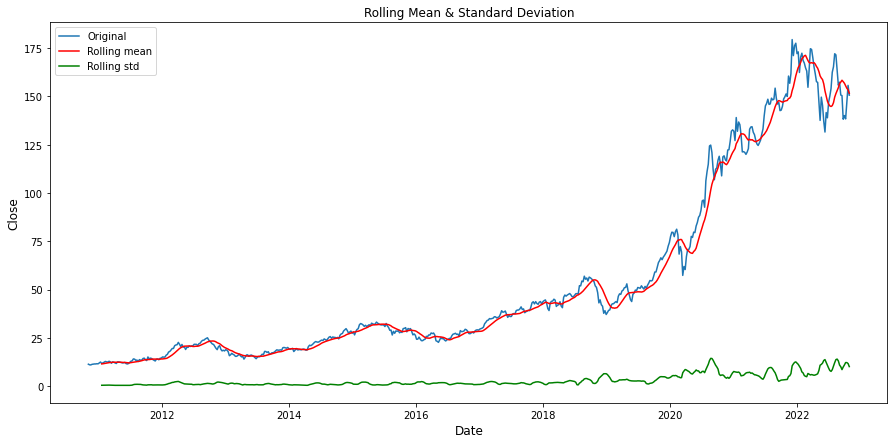

In [31]:
plt.figure(figsize=(15,7))
plt.plot(df["Close"], label='Original')
plt.plot(df["Close"].rolling(window=12).mean(), color='red', label='Rolling mean')
plt.plot(df["Close"].rolling(window=12).std(), color='green', label='Rolling std')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [32]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   
ADF_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   0.729666
p-value                          0.990412
Lags Used                       17.000000
Number of Observations Used    609.000000
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
Critical Value (10%)            -2.569304
dtype: float64


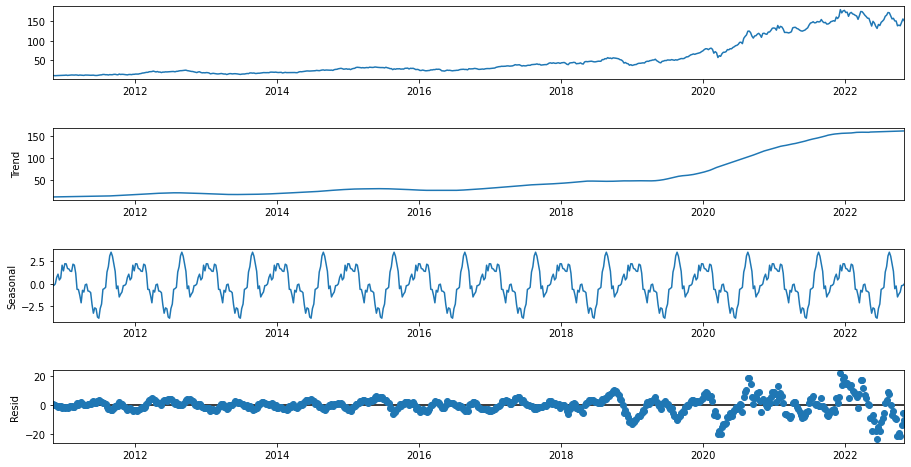

In [33]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual
 
trend, seasonal, residual = seasonal_decompose(df)

In [34]:
train_data = df['Close'][:int(len(df)*0.95)]
test_data = df['Close'][int(len(df)*0.95):]

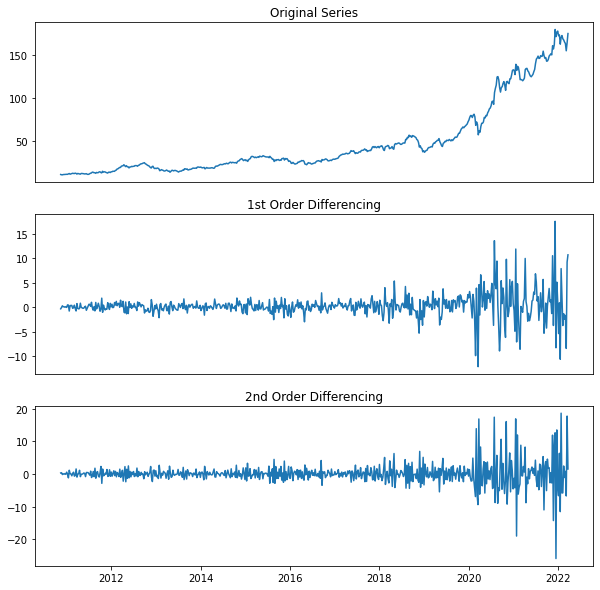

In [35]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
ax1.plot(train_data)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

Text(0.5, 1.0, 'Autocorrelation for second-order differencing')

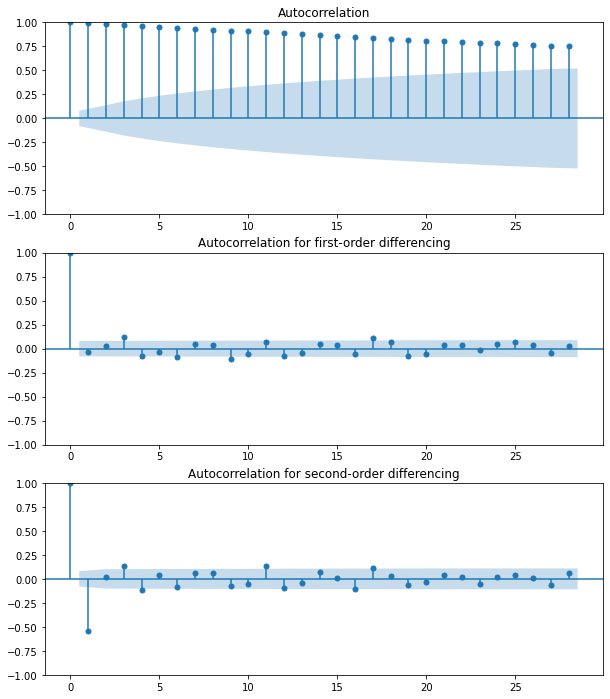

In [36]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
_ = plot_acf(train_data, ax=ax1)
_ = plot_acf(train_data.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

/Users/johnoconnell/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


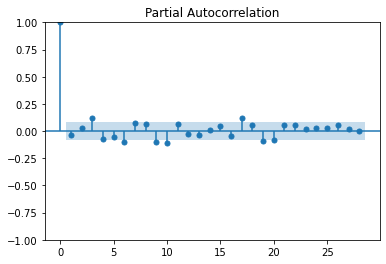

In [37]:

_ = plot_pacf(train_data.diff().dropna())

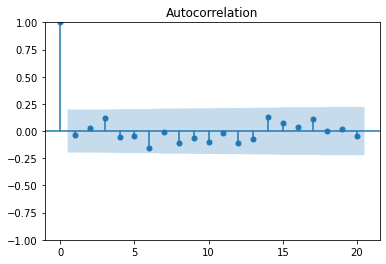

In [12]:
_ = plot_acf(train_data.diff().dropna())

In [13]:
ARIMA_model = pm.auto_arima(train_data, test = 'adf', D=1)
ARIMA_model.summary()

/Users/johnoconnell/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/johnoconnell/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/johnoconnell/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/johnoconnell/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -304.657
Date:                Tue, 13 Dec 2022   AIC                            611.314
Time:                        14:36:12   BIC                            613.899
Sample:                    11-02-2020   HQIC                           612.359
                         - 09-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.3594      3.840      7.646      0.000      21.834      36.885
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.13
Prob(Q):                              0.70   Prob(JB):                         0.21
Heteroskedasticity (H):               2.27   Skew:                             0.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model = ARIMA(train_data, order=(3, 1, 2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  595
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1356.808
Date:                Tue, 13 Dec 2022   AIC                           2725.615
Time:                        20:47:25   BIC                           2751.936
Sample:                    11-01-2010   HQIC                          2735.866
                         - 03-21-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4050      0.031     13.215      0.000       0.345       0.465
ar.L2         -0.7595      0.034    -22.350      0.000      -0.826      -0.693
ar.L3          0.0587      0.023      2.566      0.010       0.014       0.104
ma.L1         -0.4461      0.024    -18.362      0.000      -0.494      -0.399
ma.L2          0.8983      0.023     38.686      0.000       0.853       0.944
sigma2         5.6375      0.149     37.792      0.000       5.345       5.930
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2710.43
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              30.42   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0, 0.5, 'Passengers')

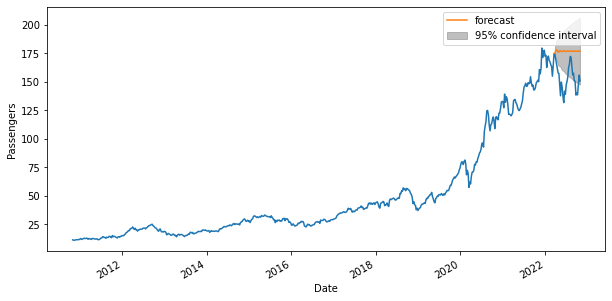

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plt.plot(df)
plot_predict(model_fit, start=len(train_data), end=(len(df)-1), ax=axs)
plt.xlabel('Date')
plt.ylabel('Passengers')